In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# needed for dynamic axis
import matplotlib.ticker as ticker
# needed for multicolor line
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
data = pd.read_csv("data/Environment_Temperature_change_E_All_Data_NOFLAG.csv", encoding= "latin1")

In [4]:
# ELIMINATING USELESS COLUMNS
data = data.drop(labels = ["Unit", "Months Code"], axis=1)

# STANDARIZING COLUMN NAMES

# standard cleaning
data.columns = [column.lower().strip() for column in list(data.columns)]

# eliminating "Y" from year columns and casting them as integers
    ## retrieving years with "y"
years = [year for year in list(data.columns) if year[0] == "y"]
    ## creating fixed years
f_years = [year.replace("y","") for year in years]
    ## merging lists
mapped_years = zip(years, f_years)
    ## dictionary comprehension for creating new_cols dictionary. This is the argument of the name method
new_cols = {key:int(value) for key,value in mapped_years}
    ## executing rename
data = data.rename(columns = new_cols)
    ## cleaining temp variables
del years
del f_years
del mapped_years
del new_cols

In [5]:
# STANDARIZING COUNTRY NAMES
    ## extracting countries with paranthesis in their name and creating df
country_df = data["area"].str.extract("(?P<country>.*)(?P<other>\(.*\))").dropna()
    ## eliminating annoying whitespace
country_df["country"] = country_df["country"].str.strip()
    ## extracting indexes 
indexes = (index for index in country_df.index)
    ## replacing indicated indeces in parent df
for index in indexes:
    data.loc[index,"area"] = country_df.loc[index,"country"]

In [6]:
# CLEANING MONTHS NAMES
    ## Cleaning Quarters with encoding difficulties
data["months"] = data["months"].str.replace("\x96", "-")

In [103]:
# creating sliced country dataframe
    ## instantiating limiting variables
country = "Nicaragua"
month = "Meteorological year"
start_year =  1992
end_year = 2019
    ## filtering
country_data = data[(data["area"] == country) & (data["months"] == month)]
    ## transposing and deleting unnecesary data
country_data = country_data.T
country_data = country_data.drop(['area code','area','months','element code','element'], axis=0)
    ## reassigning column and adjusting type again
country_data.columns = ["Temperature Anomaly", "Deviation of Anomaly"]
    ## filtering based on desired years
country_data = country_data.loc[start_year:end_year]
    ## adding std limits
country_data["+1 std"] = country_data["Temperature Anomaly"] + country_data["Deviation of Anomaly"]
country_data["-1 std"] = country_data["Temperature Anomaly"] - country_data["Deviation of Anomaly"]
country_data = country_data.astype("float")
    ## creating color map of result for easier plotting
country_data["color"] = np.where(country_data["Temperature Anomaly"] > 0, "red", "blue")
    ## fixing index dtype
country_data.index = country_data.index.astype(int)

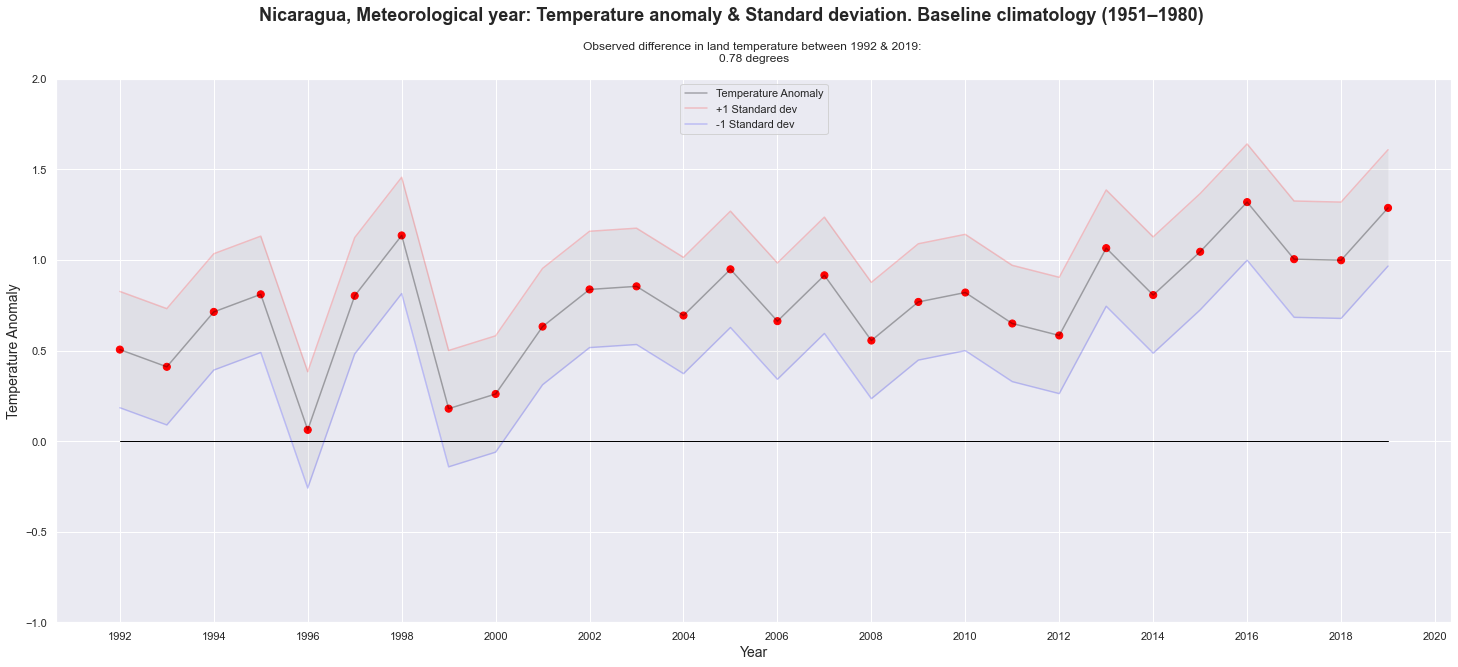

In [106]:
# setting figsize
plt.figure(figsize=(25,10))
plt.suptitle(t=country + ", " + month + ": Temperature anomaly & Standard deviation. Baseline climatology (1951–1980)", fontproperties = {"size":18, "weight":"bold"})
plt.title(label = f'''Observed difference in land temperature between {start_year} & {end_year}: 
{round(country_data.loc[end_year].loc['Temperature Anomaly'] - country_data.loc[start_year].loc['Temperature Anomaly'], 2)} degrees
''', fontdict = {"fontsize": 12})

# setting X tick range dynamically and label
    # deprecated solution
    # ax = plt.gca()
    # ax.set_xticks("lowerbound", "upperbound", "step"))
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.set_xlabel("Year", fontdict = {"fontsize": 14})

# setting Y tick range to a fixed lenght
ax.set_ylim(-1,2)
ax.set_ylabel("Temperature Anomaly", fontdict = {"fontsize": 14})

# creating general line plot
plt.plot(country_data.index, country_data["Temperature Anomaly"], alpha = 0.3, color = "black", label = "Temperature Anomaly")
plt.plot(country_data.index, [0]*country_data.index.shape[0], color="black", linewidth = 1)

# creating counter
plt.plot(country_data.index, country_data["+1 std"], alpha = 0.2, color = "red", label = "+1 Standard dev")
plt.plot(country_data.index, country_data["-1 std"], alpha = 0.2, color = "blue", label = "-1 Standard dev")
plt.fill_between(country_data.index, y1 = country_data["+1 std"], y2 = country_data["-1 std"], alpha = 0.1, facecolor = "grey")

# adding points above 0 in red and rest in blue
plt.scatter(country_data.index, country_data["Temperature Anomaly"], c = country_data["color"], s = 50)

plt.legend(loc = "upper center")
plt.show()